# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
import numpy as np
import os
from scipy.misc import imread, imresize
import datetime
import os
import pandas as pd
import matplotlib.pyplot as plt

We set the random seed so that the results don't vary drastically.

In [2]:
# image size given to us
import cv2

img = cv2.imread("Project_data/train/WIN_20180907_15_35_09_Pro_Right Swipe_new/WIN_20180907_15_35_09_Pro_00012.png")

print(img.shape)

(360, 360, 3)


In [3]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.set_random_seed(30)

Using TensorFlow backend.


In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [4]:
train_doc = np.random.permutation(open('Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('Project_data/val.csv').readlines())
#batch_size = 10 #experiment with the batch size
frames_Weneed = 30

To ease up model formation we will provide batch size later in the code 

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [5]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [idx for idx in range(0,30)] #create a list of image numbers you want to use for a particular video

    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,len(img_idx),120,120,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_data
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                   
                    #crop the images and resize them. Note that the images are of 2 different shape
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image = imresize(image,(120,120))
                    image = (image - np.min(image)) / (np.max(image) - np.min(image))
                    batch_data[folder,idx,:,:,0] = image[:,:,0] #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image[:,:,1] #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image[:,:,2] #normalise and feed in the image
                   
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

       
        # write the code for the remaining data points which are left after full batches
        if len(folder_list) != batch_size*num_batches:
            batch_size=len(folder_list) - batch_size*num_batches
            batch_data = np.zeros((batch_size,len(img_idx),120,120,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_data
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                   
                    #crop the images and resize them. Note that the images are of 2 different shape
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image = imresize(image,(120,120))
                    image = (image - np.min(image)) / (np.max(image) - np.min(image))
                    batch_data[folder,idx,:,:,0] = image[:,:,0] #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image[:,:,1] #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image[:,:,2] #normalise and feed in the image
                   
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


We will consider the set of full 30 frames so that we won't miss out any vital information during training with the image size of (120,120)

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [6]:
curr_dt_time = datetime.datetime.now()
train_path = './Project_data/train'
val_path = './Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 100 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 100


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [7]:
# Required Libraries for the modelling 
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D,Conv2D,MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.applications import ResNet50,mobilenet
from keras.applications.resnet50 import preprocess_input
from keras.layers.recurrent import LSTM, GRU
import pandas as pd 
import matplotlib.pyplot as plt



In [8]:
# 3d Convolution 
model3 = Sequential()

# layer1
model3.add(Conv3D(filters=16, kernel_size=(3,3,3), strides=(1,1,1), padding='same', input_shape=(30,120,120,3)))
model3.add(Activation('relu'))
model3.add(Dropout(0.25))
model3.add(MaxPooling3D(pool_size=(2,2,2)))

#layer2
model3.add(Conv3D(filters=32, kernel_size=(3,3,3)))
model3.add(Activation('relu'))
model3.add(MaxPooling3D(pool_size=(2,2,2)))

#layer3
model3.add(Conv3D(filters=64, kernel_size=(3,3,3), padding='same'))
model3.add(Activation('relu'))
model3.add(MaxPooling3D(pool_size=(2,2,2)))

#Layer4
model3.add(Conv3D(filters=128, kernel_size=(3,3,3), padding='same'))
model3.add(Activation('relu'))
model3.add(MaxPooling3D(pool_size=(2,2,2)))


model3.add(Flatten())
model3.add(Dense(256))
model3.add(Activation('relu'))
model3.add(Dropout(0.5))
model3.add(Dense(128))
model3.add(Activation('relu'))
model3.add(Dropout(0.5))
model3.add(Dense(5))
model3.add(Activation('softmax'))

- We will use four layer model as using more layers will overfit the model and less than four will underfit the model. 
- Kernel size of (3,3,3) is the optimal choice as it performs best in 3-D Convolution.
- Dropout of 50% is used to drop the connections between the neurons of layer which are not useable.

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [9]:
optimiser = 'adam'
model3.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model3.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 30, 120, 120, 16)  1312      
_________________________________________________________________
activation_1 (Activation)    (None, 30, 120, 120, 16)  0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 120, 120, 16)  0         
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 15, 60, 60, 16)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 13, 58, 58, 32)    13856     
_________________________________________________________________
activation_2 (Activation)    (None, 13, 58, 58, 32)    0         
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 6, 29, 29, 32)     0         
__________

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [10]:
batch_size = 20
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [11]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

# We have changed the Check point so that the best model gets saved. we are getting some NO SPACE ISSUE in NImbleBox, hence we have to do so
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, cooldown=1, verbose=1)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [12]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [13]:
num_epochs = 30
model3.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  ./Project_data/val ; batch size = 20
Source path =  ./Project_data/train ; batch size = 20
Epoch 1/30


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  from ipykernel import kernelapp as app
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


32/34 [===========================>..] - ETA: 14s - loss: 1.6121 - categorical_accuracy: 0.2000

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:38: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


34/34 [==============================] - 248s 7s/step - loss: 1.6126 - categorical_accuracy: 0.1943 - val_loss: 1.5931 - val_categorical_accuracy: 0.2300

Epoch 00001: saving model to model_init_2020-04-1115_43_38.721918/model-00001-1.61146-0.19910-1.59307-0.23000.h5
Epoch 2/30
34/34 [==============================] - 17s 497ms/step - loss: 1.5917 - categorical_accuracy: 0.2353 - val_loss: 1.5058 - val_categorical_accuracy: 0.3800

Epoch 00002: saving model to model_init_2020-04-1115_43_38.721918/model-00002-1.59172-0.23529-1.50581-0.38000.h5
Epoch 3/30
34/34 [==============================] - 17s 513ms/step - loss: 1.6157 - categorical_accuracy: 0.2255 - val_loss: 1.6082 - val_categorical_accuracy: 0.2100

Epoch 00003: saving model to model_init_2020-04-1115_43_38.721918/model-00003-1.61570-0.22549-1.60820-0.21000.h5
Epoch 4/30
34/34 [==============================] - 20s 598ms/step - loss: 1.6343 - categorical_accuracy: 0.2549 - val_loss: 1.6065 - val_categorical_accuracy: 0.2200

Ep


Epoch 00029: saving model to model_init_2020-04-1115_43_38.721918/model-00029-1.22619-0.47059-1.17403-0.49000.h5
Epoch 30/30
34/34 [==============================] - 17s 496ms/step - loss: 1.2878 - categorical_accuracy: 0.4314 - val_loss: 1.1884 - val_categorical_accuracy: 0.4600

Epoch 00030: saving model to model_init_2020-04-1115_43_38.721918/model-00030-1.28780-0.43137-1.18843-0.46000.h5


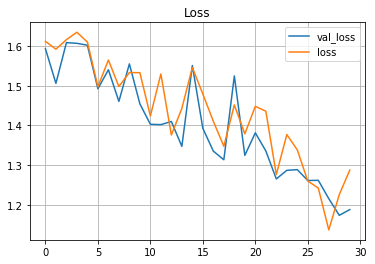

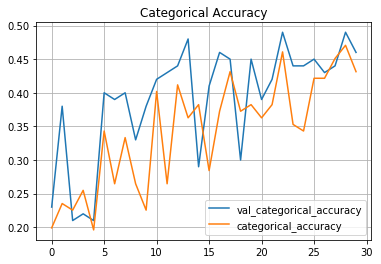

In [61]:
model3_data = pd.DataFrame(model3.history.history)

model3_data[['val_loss','loss']].plot(title='Loss', grid=True)
model3_data[['val_categorical_accuracy','categorical_accuracy']].plot(title='Categorical Accuracy', grid=True)
plt.show()

In [14]:
# we change the filter size to (8,16,32,64) and remove dropout from convolution layers 
model2 = Sequential()

# layer1
model2.add(Conv3D(filters=8, kernel_size=(3,3,3), padding='same', input_shape=(30,120,120,3)))
model2.add(Activation('relu'))
model2.add(MaxPooling3D(pool_size=(2,2,2)))

#layer2
model2.add(Conv3D(filters=16, kernel_size=(3,3,3)))
model2.add(Activation('relu'))
model2.add(MaxPooling3D(pool_size=(2,2,2)))

#layer3
model2.add(Conv3D(filters=32, kernel_size=(1,3,3), padding='same'))
model2.add(Activation('relu'))
model2.add(MaxPooling3D(pool_size=(2,2,2)))

#Layer4
model2.add(Conv3D(filters=64, kernel_size=(1,3,3), padding='same'))
model2.add(Activation('relu'))
model2.add(MaxPooling3D(pool_size=(2,2,2)))


model2.add(Flatten())
model2.add(Dense(256))
model2.add(Activation('relu'))
model2.add(Dropout(0.5))
model2.add(Dense(128))
model2.add(Activation('relu'))
model2.add(Dropout(0.5))
model2.add(Dense(5))
model2.add(Activation('softmax'))

optimiser = 'adam'
model2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model2.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_5 (Conv3D)            (None, 30, 120, 120, 8)   656       
_________________________________________________________________
activation_8 (Activation)    (None, 30, 120, 120, 8)   0         
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 (None, 15, 60, 60, 8)     0         
_________________________________________________________________
conv3d_6 (Conv3D)            (None, 13, 58, 58, 16)    3472      
_________________________________________________________________
activation_9 (Activation)    (None, 13, 58, 58, 16)    0         
_________________________________________________________________
max_pooling3d_6 (MaxPooling3 (None, 6, 29, 29, 16)     0         
_________________________________________________________________
conv3d_7 (Conv3D)            (None, 6, 29, 29, 32)     4640      
__________

In [15]:
batch_size = 40
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

# We have changed the Check point so that the best model gets saved. we are getting some NO SPACE ISSUE in NImbleBox, hence we have to do so
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, cooldown=1, verbose=1)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
    
num_epochs = 50
model2.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  ./Project_data/val ; batch size = 40
Source path =  ./Project_data/train ; batch size = 40
Epoch 1/50


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  from ipykernel import kernelapp as app
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


 2/17 [==>...........................] - ETA: 1:31 - loss: 1.6215 - categorical_accuracy: 0.2000

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:38: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


17/17 [==============================] - 87s 5s/step - loss: 1.6010 - categorical_accuracy: 0.2050 - val_loss: 1.5275 - val_categorical_accuracy: 0.2300

Epoch 00001: saving model to model_init_2020-04-1115_43_38.721918/model-00001-1.60203-0.20362-1.52755-0.23000.h5
Epoch 2/50
17/17 [==============================] - 43s 3s/step - loss: 1.5241 - categorical_accuracy: 0.2813 - val_loss: 1.4251 - val_categorical_accuracy: 0.3500

Epoch 00002: saving model to model_init_2020-04-1115_43_38.721918/model-00002-1.52410-0.28133-1.42514-0.35000.h5
Epoch 3/50
17/17 [==============================] - 45s 3s/step - loss: 1.4914 - categorical_accuracy: 0.3279 - val_loss: 1.3591 - val_categorical_accuracy: 0.5000

Epoch 00003: saving model to model_init_2020-04-1115_43_38.721918/model-00003-1.49114-0.32698-1.35910-0.50000.h5
Epoch 4/50
17/17 [==============================] - 38s 2s/step - loss: 1.3599 - categorical_accuracy: 0.3963 - val_loss: 1.2372 - val_categorical_accuracy: 0.4167

Epoch 00004:

17/17 [==============================] - 36s 2s/step - loss: 0.5341 - categorical_accuracy: 0.8028 - val_loss: 0.5879 - val_categorical_accuracy: 0.7500

Epoch 00030: saving model to model_init_2020-04-1115_43_38.721918/model-00030-0.53408-0.80277-0.58794-0.75000.h5
Epoch 31/50
17/17 [==============================] - 36s 2s/step - loss: 0.5104 - categorical_accuracy: 0.7682 - val_loss: 0.8144 - val_categorical_accuracy: 0.6833

Epoch 00031: saving model to model_init_2020-04-1115_43_38.721918/model-00031-0.51043-0.76817-0.81440-0.68333.h5
Epoch 32/50
17/17 [==============================] - 35s 2s/step - loss: 0.4699 - categorical_accuracy: 0.8097 - val_loss: 0.8773 - val_categorical_accuracy: 0.6667

Epoch 00032: saving model to model_init_2020-04-1115_43_38.721918/model-00032-0.46990-0.80969-0.87729-0.66667.h5
Epoch 33/50
17/17 [==============================] - 35s 2s/step - loss: 0.4586 - categorical_accuracy: 0.8131 - val_loss: 0.6305 - val_categorical_accuracy: 0.7667

Epoch 000

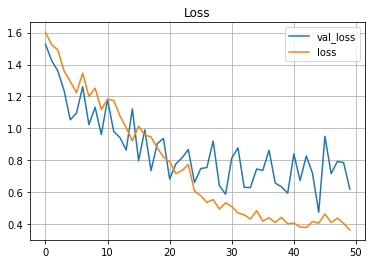

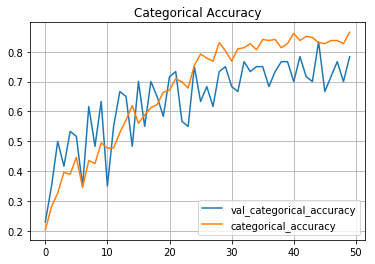

In [16]:
model2_data = pd.DataFrame(model2.history.history)

model2_data[['val_loss','loss']].plot(title='Loss', grid=True)
model2_data[['val_categorical_accuracy','categorical_accuracy']].plot(title='Categorical Accuracy', grid=True)
plt.show()


Model with small filters size gives us better training and validation accuracy of 85% and 83% 

In [25]:
# Let's try anothe model by changing the filter size a bit 
model4 = Sequential()

# layer1
model4.add(Conv3D(filters=8, kernel_size=(3,3,3), padding='same', input_shape=(30,120,120,3)))
model4.add(Activation('relu'))
model4.add(MaxPooling3D(pool_size=(2,2,2)))

#layer2
model4.add(Conv3D(filters=16, kernel_size=(3,3,3)))
model4.add(Activation('relu'))
model4.add(MaxPooling3D(pool_size=(2,2,2)))

#layer3
model4.add(Conv3D(filters=32, kernel_size=(3,3,3), padding='same'))
model4.add(Activation('relu'))
model4.add(MaxPooling3D(pool_size=(2,2,2)))

#Layer4
model4.add(Conv3D(filters=32, kernel_size=(3,3,3), padding='same'))
model4.add(Activation('relu'))
model4.add(MaxPooling3D(pool_size=(2,2,2)))


model4.add(Flatten())
model4.add(Dense(256))
model4.add(Activation('relu'))
model4.add(Dropout(0.5))
model4.add(Dense(128))
model4.add(Activation('relu'))
model4.add(Dropout(0.5))
model4.add(Dense(5))
model4.add(Activation('softmax'))

optimiser = 'adam'
model4.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model4.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_17 (Conv3D)           (None, 30, 120, 120, 8)   656       
_________________________________________________________________
activation_29 (Activation)   (None, 30, 120, 120, 8)   0         
_________________________________________________________________
max_pooling3d_17 (MaxPooling (None, 15, 60, 60, 8)     0         
_________________________________________________________________
conv3d_18 (Conv3D)           (None, 13, 58, 58, 16)    3472      
_________________________________________________________________
activation_30 (Activation)   (None, 13, 58, 58, 16)    0         
_________________________________________________________________
max_pooling3d_18 (MaxPooling (None, 6, 29, 29, 16)     0         
_________________________________________________________________
conv3d_19 (Conv3D)           (None, 6, 29, 29, 32)     13856     
__________

In [26]:
batch_size = 50
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

# We have changed the Check point so that the best model gets saved. we are getting some NO SPACE ISSUE in NImbleBox, hence we have to do so
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, cooldown=1, verbose=1)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
    
num_epochs = 35
model4.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  ./Project_data/val ; batch size = 50
Source path =  ./Project_data/train ; batch size = 50
Epoch 1/35


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  from ipykernel import kernelapp as app
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


12/14 [========================>.....] - ETA: 13s - loss: 1.6070 - categorical_accuracy: 0.2200

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:38: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


14/14 [==============================] - 93s 7s/step - loss: 1.6047 - categorical_accuracy: 0.2155 - val_loss: 1.5639 - val_categorical_accuracy: 0.2400

Epoch 00001: saving model to model_init_2020-04-1115_43_38.721918/model-00001-1.60462-0.21870-1.56389-0.24000.h5
Epoch 2/35
14/14 [==============================] - 23s 2s/step - loss: 1.5703 - categorical_accuracy: 0.2418 - val_loss: 1.5087 - val_categorical_accuracy: 0.2500

Epoch 00002: saving model to model_init_2020-04-1115_43_38.721918/model-00002-1.57029-0.24176-1.50873-0.25000.h5
Epoch 3/35
14/14 [==============================] - 24s 2s/step - loss: 1.5768 - categorical_accuracy: 0.2692 - val_loss: 1.5525 - val_categorical_accuracy: 0.4400

Epoch 00003: saving model to model_init_2020-04-1115_43_38.721918/model-00003-1.57683-0.26923-1.55248-0.44000.h5
Epoch 4/35
14/14 [==============================] - 24s 2s/step - loss: 1.5182 - categorical_accuracy: 0.3187 - val_loss: 1.4458 - val_categorical_accuracy: 0.4000

Epoch 00004:


Epoch 00030: saving model to model_init_2020-04-1115_43_38.721918/model-00030-0.92744-0.59341-0.94072-0.55000.h5

Epoch 00030: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 31/35
14/14 [==============================] - 23s 2s/step - loss: 0.8256 - categorical_accuracy: 0.6209 - val_loss: 0.7848 - val_categorical_accuracy: 0.7100

Epoch 00031: saving model to model_init_2020-04-1115_43_38.721918/model-00031-0.82562-0.62088-0.78480-0.71000.h5
Epoch 32/35
14/14 [==============================] - 24s 2s/step - loss: 0.6331 - categorical_accuracy: 0.7637 - val_loss: 0.7475 - val_categorical_accuracy: 0.6500

Epoch 00032: saving model to model_init_2020-04-1115_43_38.721918/model-00032-0.63307-0.76374-0.74747-0.65000.h5
Epoch 33/35
14/14 [==============================] - 26s 2s/step - loss: 0.6865 - categorical_accuracy: 0.7033 - val_loss: 0.7457 - val_categorical_accuracy: 0.7000

Epoch 00033: saving model to model_init_2020-04-1115_43_38.721918/model-00033-0.6

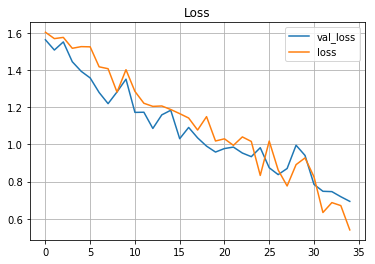

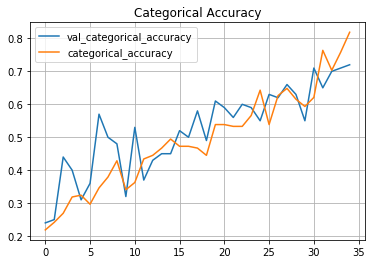

In [27]:
model4_data = pd.DataFrame(model4.history.history)

model4_data[['val_loss','loss']].plot(title='Loss', grid=True)
model4_data[['val_categorical_accuracy','categorical_accuracy']].plot(title='Categorical Accuracy', grid=True)
plt.show()

In [36]:
# CNN-RNN experiments 

# Transfer learning cnn-rnn model using LSTM and resnet
# We will import mobilenet model from the keras library 
resnet_transfer = ResNet50(weights='imagenet', include_top=False)

model_res = Sequential()
model_res.add(TimeDistributed(resnet_transfer,input_shape=(30,120,120,3)))
        
model = Model()  
for layer in model.layers:
    layer.trainable = False
        
# We would not add any extra convolution layer on the existing mobilenet model        
model_res.add(TimeDistributed(BatchNormalization()))
model_res.add(TimeDistributed(MaxPooling2D((2, 2))))
model_res.add(TimeDistributed(Flatten()))

model_res.add(GRU(128))
model_res.add(Dropout(0.25))
        
model_res.add(Dense(512,activation='relu'))
model_res.add(Dropout(0.5))

model_res.add(Dense(256, activation='relu'))
model_res.add(Dropout(0.5))

        
model_res.add(Dense(5, activation='softmax'))
        
        
optimiser = 'adam'
model_res.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

print(model_res.summary())

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/keras_applications/resnet50.py:263: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_10 (TimeDis (None, 30, 4, 4, 2048)    23587712  
_________________________________________________________________
time_distributed_11 (TimeDis (None, 30, 4, 4, 2048)    8192      
_________________________________________________________________
time_distributed_12 (TimeDis (None, 30, 2, 2, 2048)    0         
_________________________________________________________________
time_distributed_13 (TimeDis (None, 30, 8192)          0         
_________________________________________________________________
gru_2 (GRU)                  (None, 128)               3195264   
_________________________________________________________________
dropout_16 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 512)               66048     
__________

For **CNN + RNN** experimentation, we are decreasing the number of frames for the modelling as 30 frames are giving us resource exhaustion error 

In [38]:
frames_Weneed = 16

def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [idx for idx in range(0, frames_Weneed)] #create a list of image numbers you want to use for a particular video

    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,len(img_idx),120,120,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_data
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                   
                    #crop the images and resize them. Note that the images are of 2 different shape
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image = imresize(image,(120,120))
                    image = (image - np.min(image)) / (np.max(image) - np.min(image))
                    batch_data[folder,idx,:,:,0] = image[:,:,0] #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image[:,:,1] #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image[:,:,2] #normalise and feed in the image
                   
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

       
        # write the code for the remaining data points which are left after full batches
        if len(folder_list) != batch_size*num_batches:
            batch_size=len(folder_list) - batch_size*num_batches
            batch_data = np.zeros((batch_size,len(img_idx),120,120,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_data
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                   
                    #crop the images and resize them. Note that the images are of 2 different shape
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image = imresize(image,(120,120))
                    image = (image - np.min(image)) / (np.max(image) - np.min(image))
                    batch_data[folder,idx,:,:,0] = image[:,:,0] #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image[:,:,1] #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image[:,:,2] #normalise and feed in the image
                   
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

Let's built a custom CNN-RNNm model 

In [41]:
model_cnn_rnn = Sequential()


model_cnn_rnn.add(TimeDistributed(Conv2D(8, (3, 3), strides=(2, 2),activation='relu', padding='same'), input_shape=(16,120,120,3)))


model_cnn_rnn.add(TimeDistributed(Conv2D(16, (3,3),padding='same', activation='relu')))

model_cnn_rnn.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model_cnn_rnn.add(TimeDistributed(Conv2D(32, (3,3),padding='same', activation='relu')))

model_cnn_rnn.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model_cnn_rnn.add(TimeDistributed(Conv2D(64, (2,2),padding='same', activation='relu')))

model_cnn_rnn.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))


model_cnn_rnn.add(TimeDistributed(BatchNormalization()))
model_cnn_rnn.add(Dropout(0.25))

model_cnn_rnn.add(TimeDistributed(Flatten()))

model_cnn_rnn.add(Dense(256, activation='relu'))
model_cnn_rnn.add(Dropout(0.5))
model_cnn_rnn.add(Dense(128, activation='relu'))
model_cnn_rnn.add(Dropout(0.5))


model_cnn_rnn.add(GRU(128, return_sequences=False))
model_cnn_rnn.add(Dense(5, activation='softmax'))

optimiser = 'adam'
model_cnn_rnn.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model_cnn_rnn.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_32 (TimeDis (None, 16, 60, 60, 8)     224       
_________________________________________________________________
time_distributed_33 (TimeDis (None, 16, 60, 60, 16)    1168      
_________________________________________________________________
time_distributed_34 (TimeDis (None, 16, 30, 30, 16)    0         
_________________________________________________________________
time_distributed_35 (TimeDis (None, 16, 30, 30, 32)    4640      
_________________________________________________________________
time_distributed_36 (TimeDis (None, 16, 15, 15, 32)    0         
_________________________________________________________________
time_distributed_37 (TimeDis (None, 16, 15, 15, 64)    8256      
_________________________________________________________________
time_distributed_38 (TimeDis (None, 16, 7, 7, 64)      0         
__________

In [42]:
batch_size = 15
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

# We have changed the Check point so that the best model gets saved. we are getting some NO SPACE ISSUE in NImbleBox, hence we have to do so
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, cooldown=1, verbose=1)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
    
num_epochs = 25
model_cnn_rnn.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path = Source path =  ./Project_data/train ; batch size = 15
Epoch 1/25
 ./Project_data/val ; batch size = 15


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


45/45 [==============================] - 49s 1s/step - loss: 1.3375 - categorical_accuracy: 0.4221 - val_loss: 3.6464 - val_categorical_accuracy: 0.2300

Epoch 00001: saving model to model_init_2020-04-1115_43_38.721918/model-00001-1.34905-0.41780-3.64642-0.23000.h5
Epoch 2/25
45/45 [==============================] - 8s 173ms/step - loss: 1.1644 - categorical_accuracy: 0.5407 - val_loss: 3.1367 - val_categorical_accuracy: 0.2571

Epoch 00002: saving model to model_init_2020-04-1115_43_38.721918/model-00002-1.16443-0.54074-3.13669-0.25714.h5
Epoch 3/25
45/45 [==============================] - 10s 220ms/step - loss: 1.1290 - categorical_accuracy: 0.5185 - val_loss: 3.3028 - val_categorical_accuracy: 0.3429

Epoch 00003: saving model to model_init_2020-04-1115_43_38.721918/model-00003-1.12897-0.51852-3.30283-0.34286.h5
Epoch 4/25
45/45 [==============================] - 10s 217ms/step - loss: 1.4743 - categorical_accuracy: 0.4296 - val_loss: 2.8764 - val_categorical_accuracy: 0.3000

Epoc

The custom CNN-RNN model results in high training accuracy of 95% and very low validation accuracy of 58% which clearly states that the model is overfitting. So we try the same model with different batch size

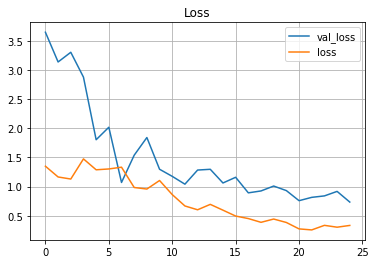

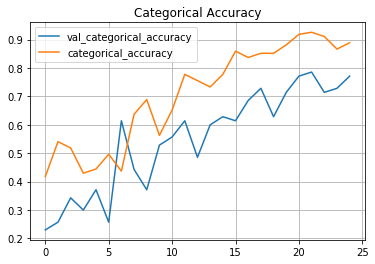

In [45]:
model_cnn_rnn = pd.DataFrame(model_cnn_rnn.history.history)

model_cnn_rnn[['val_loss','loss']].plot(title='Loss', grid=True)
model_cnn_rnn[['val_categorical_accuracy','categorical_accuracy']].plot(title='Categorical Accuracy', grid=True)
plt.show()


In [46]:
model_cnn_rnn2 = Sequential()


model_cnn_rnn2.add(TimeDistributed(Conv2D(16, (3, 3), strides=(2, 2),activation='relu', padding='same'), input_shape=(16,120,120,3)))


model_cnn_rnn2.add(TimeDistributed(Conv2D(32, (3,3),padding='same', activation='relu')))

model_cnn_rnn2.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model_cnn_rnn2.add(TimeDistributed(Conv2D(64, (3,3),padding='same', activation='relu')))

model_cnn_rnn2.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model_cnn_rnn2.add(TimeDistributed(Conv2D(128, (2,2),padding='same', activation='relu')))

model_cnn_rnn2.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))


model_cnn_rnn2.add(TimeDistributed(BatchNormalization()))
model_cnn_rnn2.add(Dropout(0.25))

model_cnn_rnn2.add(TimeDistributed(Flatten()))

model_cnn_rnn2.add(Dense(256, activation='relu'))
model_cnn_rnn2.add(Dropout(0.5))
model_cnn_rnn2.add(Dense(128, activation='relu'))
model_cnn_rnn2.add(Dropout(0.5))


model_cnn_rnn2.add(GRU(128, return_sequences=False))
model_cnn_rnn2.add(Dense(5, activation='softmax'))

optimiser = 'adam'
model_cnn_rnn2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model_cnn_rnn2.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_50 (TimeDis (None, 16, 60, 60, 16)    448       
_________________________________________________________________
time_distributed_51 (TimeDis (None, 16, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_52 (TimeDis (None, 16, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_53 (TimeDis (None, 16, 30, 30, 64)    18496     
_________________________________________________________________
time_distributed_54 (TimeDis (None, 16, 15, 15, 64)    0         
_________________________________________________________________
time_distributed_55 (TimeDis (None, 16, 15, 15, 128)   32896     
_________________________________________________________________
time_distributed_56 (TimeDis (None, 16, 7, 7, 128)     0         
__________

In [47]:
batch_size = 40
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

# We have changed the Check point so that the best model gets saved. we are getting some NO SPACE ISSUE in NImbleBox, hence we have to do so
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, cooldown=1, verbose=1)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
    
num_epochs = 25
model_cnn_rnn2.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  ./Project_data/val ; batch size = 40
Source path =  ./Project_data/train ; batch size = 40
Epoch 1/25


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


17/17 [==============================] - 51s 3s/step - loss: 1.3194 - categorical_accuracy: 0.4295 - val_loss: 1.5712 - val_categorical_accuracy: 0.3700

Epoch 00001: saving model to model_init_2020-04-1115_43_38.721918/model-00001-1.32508-0.42836-1.57120-0.37000.h5
Epoch 2/25
17/17 [==============================] - 12s 683ms/step - loss: 1.1428 - categorical_accuracy: 0.5217 - val_loss: 1.8071 - val_categorical_accuracy: 0.5167

Epoch 00002: saving model to model_init_2020-04-1115_43_38.721918/model-00002-1.14277-0.52174-1.80713-0.51667.h5
Epoch 3/25
17/17 [==============================] - 24s 1s/step - loss: 0.9393 - categorical_accuracy: 0.6193 - val_loss: 1.7268 - val_categorical_accuracy: 0.5833

Epoch 00003: saving model to model_init_2020-04-1115_43_38.721918/model-00003-0.94700-0.61580-1.72680-0.58333.h5
Epoch 4/25
17/17 [==============================] - 21s 1s/step - loss: 0.7688 - categorical_accuracy: 0.7028 - val_loss: 1.7674 - val_categorical_accuracy: 0.5833

Epoch 000

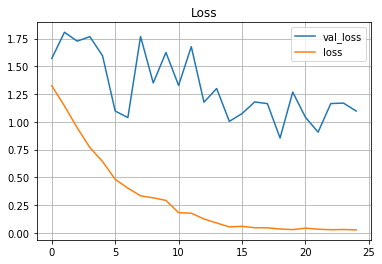

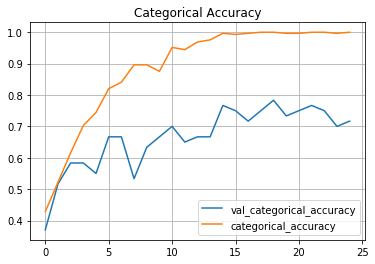

In [56]:
model_cnn_rnn2 = pd.DataFrame(model_cnn_rnn2.history.history)

model_cnn_rnn2[['val_loss','loss']].plot(title='Loss', grid=True)
model_cnn_rnn2[['val_categorical_accuracy','categorical_accuracy']].plot(title='Categorical Accuracy', grid=True)
plt.show()

In [57]:
# GRU Model using mobilenet

mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

model_mobile_net_gru = Sequential()
model_mobile_net_gru.add(TimeDistributed(mobilenet_transfer,input_shape=(16,120,120,3)))
        
        
for layer in model.layers:
    layer.trainable = False
        
        
model_mobile_net_gru.add(TimeDistributed(BatchNormalization()))
model_mobile_net_gru.add(TimeDistributed(MaxPooling2D((2, 2))))
model_mobile_net_gru.add(TimeDistributed(Flatten()))

model_mobile_net_gru.add(GRU(128))
model_mobile_net_gru.add(Dropout(0.25))
        
model_mobile_net_gru.add(Dense(128,activation='relu'))
model_mobile_net_gru.add(Dropout(0.25))
        
model_mobile_net_gru.add(Dense(5, activation='softmax'))

optimiser = 'adam'
model_mobile_net_gru.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/keras_applications/mobilenet.py:206: UserWarning: MobileNet shape is undefined. Weights for input shape (224, 224) will be loaded.
  warnings.warn('MobileNet shape is undefined.'


17227776/17225924 [==============================] - 2s 0us/step


In [58]:
model_mobile_net_gru.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_75 (TimeDis (None, 16, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_76 (TimeDis (None, 16, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_77 (TimeDis (None, 16, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_78 (TimeDis (None, 16, 1024)          0         
_________________________________________________________________
gru_10 (GRU)                 (None, 128)               442752    
_________________________________________________________________
dropout_42 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_45 (Dense)             (None, 128)               16512     
__________

In [59]:
batch_size = 5
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

# We have changed the Check point so that the best model gets saved. we are getting some NO SPACE ISSUE in NImbleBox, hence we have to do so
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, cooldown=1, verbose=1)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
    
num_epochs = 30
model_mobile_net_gru.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  ./Project_data/val ; batch size = 5
Source path =  ./Project_data/train ; batch size = 5
Epoch 1/30


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


126/133 [===========================>..] - ETA: 4s - loss: 1.3615 - categorical_accuracy: 0.4556

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


133/133 [==============================] - 83s 626ms/step - loss: 1.3405 - categorical_accuracy: 0.4642 - val_loss: 0.9124 - val_categorical_accuracy: 0.6700

Epoch 00001: saving model to model_init_2020-04-1115_43_38.721918/model-00001-1.34212-0.46456-0.91242-0.67000.h5
Epoch 2/30
133/133 [==============================] - 34s 257ms/step - loss: 1.1748 - categorical_accuracy: 0.5514 - val_loss: 1.1730 - val_categorical_accuracy: 0.5000

Epoch 00002: saving model to model_init_2020-04-1115_43_38.721918/model-00002-1.17480-0.55138-1.17301-0.50000.h5
Epoch 3/30
133/133 [==============================] - 34s 255ms/step - loss: 1.1886 - categorical_accuracy: 0.5238 - val_loss: 1.3698 - val_categorical_accuracy: 0.5200

Epoch 00003: saving model to model_init_2020-04-1115_43_38.721918/model-00003-1.18864-0.52381-1.36980-0.52000.h5
Epoch 4/30
133/133 [==============================] - 34s 255ms/step - loss: 1.0116 - categorical_accuracy: 0.5940 - val_loss: 1.0704 - val_categorical_accuracy: 

133/133 [==============================] - 34s 257ms/step - loss: 0.0918 - categorical_accuracy: 0.9674 - val_loss: 0.2553 - val_categorical_accuracy: 0.9200

Epoch 00029: saving model to model_init_2020-04-1115_43_38.721918/model-00029-0.09175-0.96742-0.25535-0.92000.h5
Epoch 30/30
133/133 [==============================] - 34s 254ms/step - loss: 0.0412 - categorical_accuracy: 0.9875 - val_loss: 0.1982 - val_categorical_accuracy: 0.9400

Epoch 00030: saving model to model_init_2020-04-1115_43_38.721918/model-00030-0.04117-0.98747-0.19819-0.94000.h5


GRU model is also overfitting. We'll try this model with larger batch size again

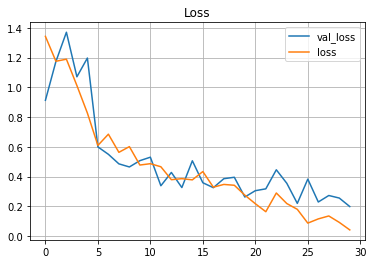

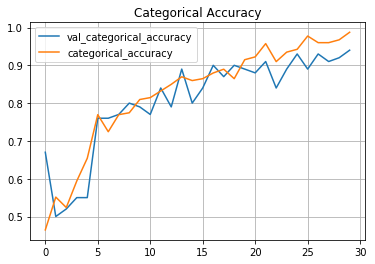

In [60]:
mobile_gru = pd.DataFrame(model_mobile_net_gru.history.history)

mobile_gru[['val_loss','loss']].plot(title='Loss', grid=True)
mobile_gru[['val_categorical_accuracy','categorical_accuracy']].plot(title='Categorical Accuracy', grid=True)
plt.show()


### Conclusion

The CNN-RNN model with Transfer learning using mobilenet gives us good accuracy on training and validation set when we use 16 frames while using the same model on 30 ferames gives us the resource exhaustion error. CNN-RNN without transfer learning overfits highly on the model. The 3D convolution performs good on the model when the model is having full 30 frames which makes it an obvious choice for the modelling for video analysis.

#### Presented By:

- Atul Mishra 
- Shreyansh Behani